<a href="https://colab.research.google.com/github/arnav39/d2el-en/blob/main/10_1_LSTMS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install matplotlib_inline
!pip install --upgrade d2l==1.0.0a0

In [2]:
import torch 
from torch import nn 
import d2l.torch as d2l

/usr/local/lib/python3.9/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [15]:
class LSTMScratch(d2l.Module):

  def __init__(self, num_inputs, num_hiddens, sigma=0.01):
    super().__init__()
    self.save_hyperparameters()

    init_weight = lambda *shape: nn.Parameter(torch.randn(*shape) * sigma)
    triple = lambda : (init_weight(num_inputs, num_hiddens),
                       init_weight(num_hiddens, num_hiddens),
                       nn.Parameter(torch.zeros(1, num_hiddens)))
    
    self.W_xi, self.W_hi, self.b_i = triple() # input_gate
    self.W_xf, self.W_hf, self.b_f = triple() # forget gate
    self.W_xo, self.W_ho, self.b_o = triple() # output gate
    self.W_xc, self.W_hc, self.b_c = triple() # input node

  def forward(self, inputs, H_C=None):
    H, C = None, None if H_C is None else H_C

    outputs = []
    for X in inputs:

      # input gate
      I = torch.sigmoid(torch.matmul(X, self.W_xi) + (torch.matmul(H, self.W_hi) if H is not None else 0) + self.b_i)
      if H is None:
        H, C = torch.zeros_like(I), torch.zeros_like(I)
      
      # Forget gate
      F = torch.sigmoid(torch.matmul(X, self.W_xf) + torch.matmul(H, self.W_hf) + self.b_f) 

      # output gate
      O = torch.sigmoid(torch.matmul(X, self.W_xo) + torch.matmul(H, self.W_ho) + self.b_o)

      # input node
      C_tilde = torch.tanh(torch.matmul(X, self.W_xc) + torch.matmul(H, self.W_hc) + self.b_c)

      C = F * C + I * C_tilde
      H = O * torch.tanh(C)
      outputs.append(H)

    return outputs, (H, C)

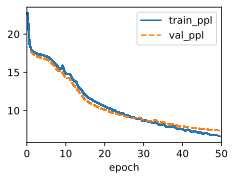

In [46]:
data = d2l.TimeMachine(batch_size=1024, num_steps=32)
lstm = LSTMScratch(num_inputs=len(data.vocab), num_hiddens=32)
model = d2l.RNNLMScratch(lstm, vocab_size=len(data.vocab), lr=4)
trainer = d2l.Trainer(max_epochs=50, gradient_clip_val=1)
trainer.fit(model, data)

- Concise Implementation : 

In [54]:
class LSTM(d2l.RNN):

  def __init__(self, num_inputs, num_hiddens):
    super().__init__()
    self.save_hyperparameters()
    self.rnn = nn.LSTM(num_inputs, num_hiddens)

  def forward(self, inputs, H_C=None):
    return self.rnn(inputs, H_C)

In [55]:
lstm = LSTM(len(data.vocab), 32) 
model = d2l.RNNLM(lstm, vocab_size = len(data.vocab), lr=4)
trainer.fit(model, data)

TypeError: ignored

In [29]:
train_loader = data.get_dataloader(train=True)

In [30]:
len(train_loader)

2500

In [34]:
feat, out = next(iter(train_loader))

In [36]:
feat.shape

torch.Size([4, 32])

In [37]:
out.shape

torch.Size([4, 32])

In [16]:
a = LSTMScratch(4, 8)

for p in a.parameters():
  print(p.shape)

torch.Size([4, 8])
torch.Size([8, 8])
torch.Size([1, 8])
torch.Size([4, 8])
torch.Size([8, 8])
torch.Size([1, 8])
torch.Size([4, 8])
torch.Size([8, 8])
torch.Size([1, 8])
torch.Size([4, 8])
torch.Size([8, 8])
torch.Size([1, 8])


In [18]:
temp = torch.randn(10, 1, 4)
outputs, (H, C) = a(temp)

In [19]:
print(len(outputs))

10


In [20]:
for o in outputs:
  print(o.shape)

torch.Size([1, 8])
torch.Size([1, 8])
torch.Size([1, 8])
torch.Size([1, 8])
torch.Size([1, 8])
torch.Size([1, 8])
torch.Size([1, 8])
torch.Size([1, 8])
torch.Size([1, 8])
torch.Size([1, 8])


In [21]:
print(H.shape)
print(C.shape)

torch.Size([1, 8])
torch.Size([1, 8])


In [22]:
outputs[-1]

tensor([[ 0.0044, -0.0111, -0.0051, -0.0013, -0.0107,  0.0084, -0.0008,  0.0014]],
       grad_fn=<MulBackward0>)

In [23]:
H

tensor([[ 0.0044, -0.0111, -0.0051, -0.0013, -0.0107,  0.0084, -0.0008,  0.0014]],
       grad_fn=<MulBackward0>)

In [24]:
C

tensor([[ 0.0087, -0.0220, -0.0101, -0.0026, -0.0212,  0.0168, -0.0015,  0.0028]],
       grad_fn=<AddBackward0>)